In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

## Enable TF eager mode

In [2]:
tf.enable_eager_execution()

## Settings

In [3]:
NUM_EPOCHS = 4
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

## Load and preprocess MNIST dataset

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28, 1) float32
(10000, 28, 28, 1) float32
(60000,) int32
(10000,) int32


## Visualize MNIST examples

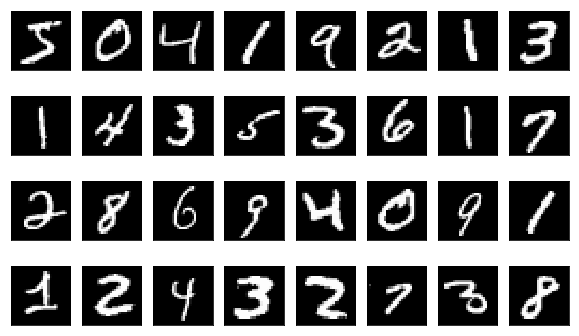

In [5]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

## Create TF data pipeline

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Create NN model class

In [7]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv2 = tf.layers.Conv2D(64, (5, 5), activation=tf.nn.relu, padding='same')
        self.fc1 = tf.layers.Dense(256, activation=tf.nn.relu)
        self.fc2 = tf.layers.Dense(10, activation=None)
        self.max_pool = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        
    def __call__(self, inp):
        
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = tf.layers.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

## Define loss and accuracy functions

In [8]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

## Create training structures

In [9]:
# optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

writer = tf.contrib.summary.create_file_writer('logs_mnsit_eager/adam')
global_step = tf.train.get_or_create_global_step()

## Run training loop

In [10]:
%%time

for (images, labels) in train_ds:
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Bacward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)
    
    # Cals and display loss/accuracy
    if global_step.numpy() % 200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
        print("[%4d] Accuracy: %5.2f %%" % (
            global_step.numpy(), accuracy_value.numpy()*100))
        
        with writer.as_default():
            with tf.contrib.summary.always_record_summaries():
                tf.contrib.summary.scalar('accuracy', accuracy_value)
                tf.contrib.summary.scalar('loss', loss_value)


[ 200] Accuracy: 94.14 %
[ 400] Accuracy: 96.48 %
[ 600] Accuracy: 98.05 %
[ 800] Accuracy: 98.05 %
[1000] Accuracy: 98.05 %
[1200] Accuracy: 99.22 %
[1400] Accuracy: 99.61 %
[1600] Accuracy: 99.22 %
[1800] Accuracy: 100.00 %
[2000] Accuracy: 100.00 %
[2200] Accuracy: 100.00 %
[2400] Accuracy: 99.61 %
[2600] Accuracy: 99.22 %
[2800] Accuracy: 100.00 %
[3000] Accuracy: 98.83 %
[3200] Accuracy: 99.61 %
[3400] Accuracy: 99.61 %
[3600] Accuracy: 99.61 %
CPU times: user 43.6 s, sys: 2.2 s, total: 45.8 s
Wall time: 34.6 s


## Calculate validation accuracy

In [11]:
%%time

test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 98.47 %
CPU times: user 180 ms, sys: 116 ms, total: 296 ms
Wall time: 296 ms


## Define function for inference and result visualization

In [12]:
def test_digit(sample):
    
    sample = sample[np.newaxis, ...]
    logits = model(sample)
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[0,:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction[0], align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted number: {}'.format(ans))

## Run inference on a random test exmaple

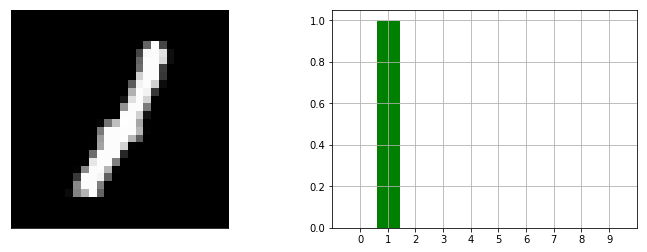

Predicted number: 1


In [13]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_digit(sample)

In [14]:
print('True Answer: {}'.format(test_y[idx]))

True Answer: 1


## Run inference on our example

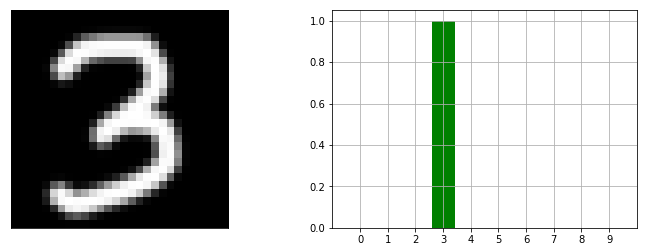

Predicted number: 3


In [15]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (28, 28), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    img = np.mean(img, axis=2)
    img = np.reshape(img, (28, 28, 1))
    return img

img = load_and_prepare_image('digit.png')
test_digit(img)

## QR code link to this demo

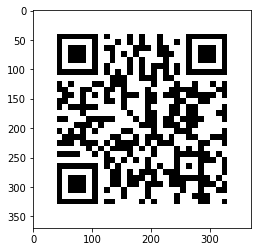

In [16]:
GITHUB_URL = 'https://github.com/dkorobchenko-nv/dl-demo'

import qrcode
fig = plt.figure(figsize=(4, 4))
_=plt.imshow(qrcode.make(GITHUB_URL))